# Chapter 6

## Problem 1

Minimize $x_1 + x_2$, such that:

$x_1 + 2x_2 \geq 3,$ 

$2x_1 + x_2 \geq 5,$ 

$x_2 \geq 0 .$

In this problem, there are two unknowns, and three constraints. Here, the objective function is
$x_1 + x_2$ .
Since there are only two variables, we can solve this problem by graphing the set
of points in the plane that satisfies all the constraints (called the constraint set) and
then, finding which point of this set minimizes the value of the objective function. Each
inequality constraint is satisfied by a half-plane of points, and the constraint set is the
intersection of all the half-planes. In the present example, the constraint set is the right-sided two cornered
unbounded figure shaded with brown ([#B8860B](http://www.color-hex.com/color/b8860b)) in following Figure.


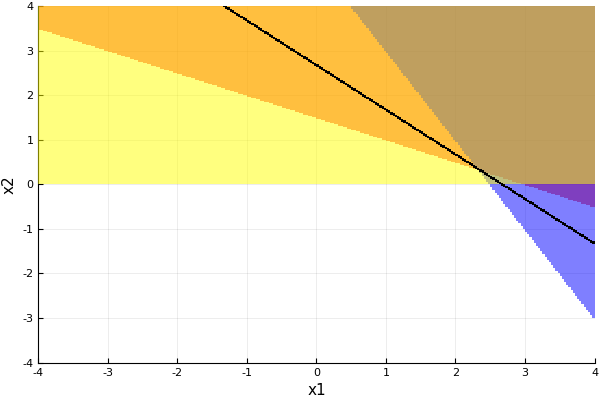

In [82]:
using ImplicitEquations, Plots
pyplot()
f(x,y) = x + 2y - 3
g(x,y) = 2x + y - 5
h(x,y) = y
l = 4
plot(Ge(f,0), xlab = "x1", ylab = "x2", xlims=(-l, l), ylims=(-l, l), fill = (0, 0.5, :red), xticks = -l:1.0:l, yticks = -l:1.0:l)
plot!(Ge(g,0), xlims=(-l, l), ylims=(-l, l), fill = (0, 0.5, :blue))
plot!(Ge(h,0), xlims=(-l, l), ylims=(-l, l), fill = (0, 0.5, :yellow))
soln(x,y) = x + y
plot!(Eq(soln,8.0/3.0), xlims=(-l, l), ylims=(-l, l))
#plot!(Ge(h,0) & Ge(f,0), xlims=(-10, 10), ylims=(-10, 10))

We seek the point $(x_1, x_2)$, that achieves the minimum of $x_1 +x_2$ as $(x_1, x_2)$ ranges
over this constraint set. The function $x_1 + x_2$ is constant on lines with slope −1, for
example the line $x_1 + x_2 = 10$, and as we move this line further towards the origin down and to
the left, the value of $x_1 + x_2$ decreases. Therefore, we seek the line of slope −1 that is
closest to the origin and still touches the constraint set. This occurs at the intersection
of the lines $x_1 +2x_2 = 3$ and $2x_1 +x_2 = 5$, namely, $(x_1, x_2) = (7/3, 1/3)$. The value of
the objective function there is $(7/3) + (1/3) = 8/3$.

In [78]:
function revised_simplex(A::SparseMatrixCSC{T}, b::Vector{T}, 
        c::Vector{T}, B::Vector{Int}, tol::T) where T <: Real
    (m, n) = size(A)
    N = setdiff(collect(1:n), B)
    ABinv = inv(full(A[:, B]))
    xB = ABinv * b
    for iteration = 1:10*m
        mu = c[N]' - (c[B]' * ABinv) * A[:, N]
        k = indmin(mu)
        if mu[k] > -tol # test for convergence
            return (dot(c[B], xB), B, xB)
        else
            d = ABinv * A[:, N[k]] # possible update directions
            p = find(d .> tol)
            if isempty(p)
                return (-Inf, nothing, nothing) # unbounded below
            end
            (t, i) = findmin(xB[p] ./ d[p])
            (B[p[i]], N[k]) = (N[k], B[p[i]]) # revise vertex set
            xB = xB - t * d
            xB[p[i]] = t
            v = ABinv[p[i], :] / d[p[i]] # Sherman-Morrison update
            d[p[i]] = d[p[i]] - one(T)
            ABinv = ABinv - d * v'
        end
    end
end

function simplex_program(A::SparseMatrixCSC{T}, b::Vector{T}, c::Vector{T}, tol::T) where T <: Real
    (m, n) = size(A)
    for i = 1:m
        if b[i] < zero(T)
            A[i, :] = - A[i, :]
            b[i] = - b[i]
        end
    end
    A1 = [A eye(T, m)]
    c1 = [zeros(T, n); ones(T, m)]
    B = collect(n + 1:m + n)
    (cost, B, xB) = revised_simplex(A1, b, c1, B, tol)
    if cost > tol
        return (Inf, nothing, nothing)
    else
        (cost, B, xB) = revised_simplex(A, b, c, B, tol)
        return (cost, B, xB)
    end
end 

c = [1.0 ;0; 0; 1.0; -1.0];
A = [ -2.0 1.0 0.0 -1.0 1.0; -1.0 0.0 1.0 -2.0 2.0 ];
b = [ -3.0; -5.0 ];
A = sparse(A);
tol = 1e-5;
(cost, B, xB) = simplex_program(A, b, c, tol)

(2.6666666666666665, [1, 4], [0.333333, 2.33333])

The solution from Simplex Julia code from class is also $2.66666... (8/3)$ at values $(2.333..., 0.333...)$.

## Problem 2

Maximize $x_1 + 2x_2 + 3x_3 + 4x_4 + 5$, such that:

$4x_1 + 3x_2 + 2x_3 + x_4 \leq 10, $

$x_1 - x_3 + 2x_4 = 2, $ 

$x_1 + x_2 + x_3 + x_4 \geq 1, $

$x_1 \geq 0, $

$x_3 \geq 0, $

$x_4 \geq 0. $

In this problem, there are 4 unknowns, and 1 equality constraint and 5 inequality constraints. Here, the objective function is $x_1 + 2x_2 + 3x_3 + 4x_4 + 5$ .

A linear programs can be expressed in canonical form as minimizing $f(x) = c^{*}x$, subject to $Ax = b$ and $x \geq 0$. 
To convert the given linear program into canonical linear program representation, we need to change the objective first to minimization, i.e. minimize $-x_1 - 2x_2 - 3x_3 - 4x_4 - 5$. We can ignore the constant (-5) from the objective as it just translates the objective. Next, we need to convert linear inequality constraints to equality constraints by introducing slack variables.

Here, the constraint $4x_1 + 3x_2 + 2x_3 + x_4 \leq 10 $ can be rewritten as 
$4x_1 + 3x_2 + 2x_3 + x_4 + s_1 = 10,  s_1 \geq 0$ by introducing the slack variable $s_1$.

Here, the constraint $x_1 + x_2 + x_3 + x_4 \geq 1 $ can be rewritten as $ - x_1 - x_2 - x_3 - x_4 \leq -1 $, which can be again rewritten as $ - x_1 - x_2 - x_3 - x_4 + s_2 = -1,  s_2 \geq 0$ by introducing the slack variable $s_2$.

However, $x_2$ is not already constrained by $x_2 \geq 0$, so we can introduce free variables $u \geq 0$ and $w \geq 0$ so that $x_2 = u - w$ and replace $x_2$ everywhere by this difference.

Hence, the given linear program, finally in its canonical representation will be:

Minimize $-x_1 - 2(u-w) - 3x_3 - 4x_4$ i.e. $-x_1 - 3x_3 - 4x_4 - 2u + 2w$, such that:

$4x_1 + 3(u-w) + 2x_3 + x_4 + s_1 = 10, i.e. 4x_1 + 2x_3 + x_4 + s_1 + 3u - 3w = 10, $

$x_1 - x_3 + 2x_4 = 2, $ 

$ - x_1 - (u-w) - x_3 - x_4 + s_2 = -1, i.e. - x_1 - x_3 - x_4 + s_2 -u + w = -1, $

$x_1 \geq 0, $

$x_3 \geq 0, $

$x_4 \geq 0, $

$s_1 \geq 0, $

$s_2 \geq 0, $

$u \geq 0, $

$w \geq 0. $

From the above canonical representation, $x = [x_1,x_3,x_4,s_1,s_2,u,w]^{*}$ and $c = [-1,-3,-4,0,0,-2,2]^{*}$ and $b = [10, 2, -1]^{*}$, i.e.,

\begin{equation}
x = \begin{pmatrix} x_1 \\ x_3 \\ x_4 \\ s_1 \\ s_2 \\ u \\ w \end{pmatrix}
\end{equation}

\begin{equation}
c = \begin{pmatrix} -1 \\ -3 \\ -4 \\ 0 \\ 0 \\ -2 \\ 2 \end{pmatrix}
\end{equation}

\begin{equation}
A = \begin{pmatrix} 4 & 2 & 1 & 1 & 0 & 3 & -3\\ 1 & -1 & 2 & 0 & 0 & 0 & 0\\ -1 & -1 & -1 & 0 & 1 & -1 & 1 \end{pmatrix}
\end{equation}

\begin{equation}
b = \begin{pmatrix} 10 \\ 2\\ -1 \end{pmatrix}
\end{equation}

To solve the above linear program, let's put it in the simplex code from the lecture.


In [93]:
c = [-1.0; -3.0; -4.0; 0.0; 0.0; -2.0; 2.0];
A = [ 4.0  2.0 1.0 1.0 0.0 3.0 -3.0; 1.0 -1.0 2.0 0.0 0.0 0.0 0.0; -1.0 -1.0 -1.0 0.0 1.0 -1.0 1.0];
b = [ 10.0; 2.0; -1.0];
A = sparse(A);
tol = 1e-5;
(cost, B, xB) = simplex_program(A, b, c, tol)

(-Inf, nothing, nothing)

The solution is unbounded below, i.e. the minimum occurs at $-\infty$ for canonical representation and hence, the maximum occurs at $\infty$ for original linear program.

## Problem 3

Minimize $|x_1 + x_2 + x_3|$, such that:

$x_1 - x_2 = 5, $

$x_2 - x_3 = 7, $ 

$x_1 \leq 0, $

$x_3 \geq 2. $

In this problem, there are 3 unknowns, and 2 equality constraints and 2 inequality constraints. Here, the objective function is $|x_1 + x_2 + x_3|$ .

A linear programs can be expressed in canonical form as minimizing $f(x) = c^{*}x$, subject to $Ax = b$ and $x \geq 0$. 
To convert the given linear program into canonical linear program representation, we need to change the objective first to minimization, i.e. minimize $x_1 + x_2 + x_3$. To take the absolute value into account, we add the constraint $x_1 + x_2 + x_3 \geq 0$. Next, we need to convert linear inequality constraints to equality constraints by introducing slack variables.

Here, the constraint $x_1 + x_2 + x_3 \geq 0 $ can be rewritten as 
$x_1 + x_2 + x_3 - s = 0,  s \geq 0$ by introducing the slack variable $s$.

However, $x_2$ is not already constrained by $x_2 \geq 0$, so we can introduce free variables $u \geq 0$ and $w \geq 0$ so that $x_2 = u - w$ and replace $x_2$ everywhere by this difference.

Here, the constraint $x_1 \leq 0 $ can be rewritten as $y_1 = -x_1,  y_1 \geq 0$ by variable substitution ($x_1 = -y_1$).

Here, the constraint $x_3 \geq 2 $ can be rewritten as $y_2 = x_3 - 2,  y_2 \geq 0$ by variable substitution ($x_3 = y_2 + 2$).

Hence, the given linear program, finally in its canonical representation will be:

Minimize $-y_1 + u - w + y_2 + 2$, such that:

$ -y_1 - u + w = 5, $

$ u - w - y_2 = 9, $ 

$ -y_1  + u - w + y_2 - s = -2, $

$y_1 \geq 0, $

$y_2 \geq 0, $

$s \geq 0, $

$u \geq 0, $

$w \geq 0. $

From the above canonical representation, $x = [y_1,y_2,s,u,w]^{*}$ and $c = [-1,1,0,1,-1]^{*}$ and $b = [5,9,-2]^{*}$, i.e.,

\begin{equation}
x = \begin{pmatrix} y_1 \\ y_2 \\ s \\ u \\ w \end{pmatrix}
\end{equation}

\begin{equation}
c = \begin{pmatrix} -1 \\ 1 \\ 0 \\ 1 \\ -1 \end{pmatrix}
\end{equation}

\begin{equation}
A = \begin{pmatrix} -1 & 0 & 0 & -1 & 1\\ 0 & -1 & 0 & 1 & -1\\ -1 & 1 & -1 & 1 & -1 \end{pmatrix}
\end{equation}

\begin{equation}
b = \begin{pmatrix} 5 \\ 9 \\ -2 \end{pmatrix}
\end{equation}

To solve the above linear program, let's put it in the simplex code from the lecture.


In [92]:
c = [-1.0; 1.0; 0.0; 1.0; -1.0]; #Wikipedia example
A = [-1.0 0.0 0.0 -1.0 1.0; 0.0 -1.0 0.0 1.0 -1.0; -1.0 1.0 -1.0 1.0 -1.0];
b = [ 5.0; 9.0; -2.0];
A = sparse(A);
tol = 1e-5;
(cost, B, xB) = simplex_program(A, b, c, tol)

(Inf, nothing, nothing)

There is no solution, i.e. the minimum occurs at $\infty$ for canonical representation and hence, there is no solution for the objective. 
This can easily be observed, if we rewrite the constraints from the original linear program in terms of $x_2$.

$x_1 = 5 + x_2 \leq 0$
$\implies x_2 \leq -5$

$x_3 = x_2 - 7 \geq 2$
$\implies x_2 \geq 9$

Clearly, no $x_2$ can satisfy the constraints and hence, the linear program has no solution at all.

## Problem 7

Consider the following constraints, where feasible region R is unbounded:

$x_1 \geq 0, $

$x_2 \geq 0. $

In this problem, there are two unknowns, and two constraints. 
Since there are only two variables, we can solve this problem by graphing the set
of points in the plane that satisfies all the constraints (called the constraint set) and
then, finding which point of this set minimizes the value of the objective function. Each
inequality constraint is satisfied by a half-plane of points, and the constraint set is the
intersection of all the half-planes. In the present example, the constraint set **R** is the right-sided two cornered
unbounded figure shaded with red in following Figure.


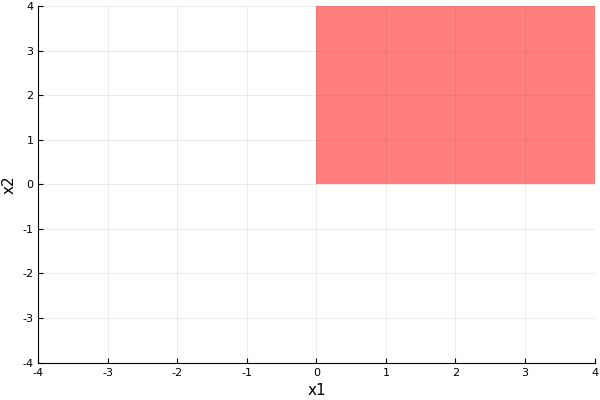

In [83]:
using ImplicitEquations, Plots
pyplot()
f(x,y) = x
h(x,y) = y
l = 4
plot(Ge(f,0) & Ge(h,0), xlab = "x1", ylab = "x2", xlims=(-l, l), ylims=(-l, l), fill = (0, 0.5, :red), xticks = -l:1.0:l, yticks = -l:1.0:l)

Now, consider the objective $x_1 + x_2$ i.e. $c = [1,1]$.
Clearly, the objective $c^{*}x$ is bounded below on *R*.
The minimum occurs, when $x_1 + x_2 = 0$ at (0,0), which is plotted next.


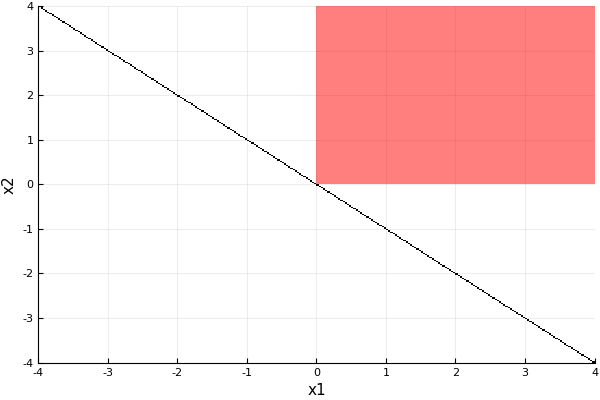

In [85]:
using ImplicitEquations, Plots
pyplot()
f(x,y) = x
h(x,y) = y
l = 4
plot(Ge(f,0) & Ge(h,0), xlab = "x1", ylab = "x2", xlims=(-l, l), ylims=(-l, l), fill = (0, 0.5, :red), xticks = -l:1.0:l, yticks = -l:1.0:l)
soln(x,y) = x + y
plot!(Eq(soln,0), xlims=(-l, l), ylims=(-l, l))

Now, consider the objective $x_1 - x_2$ i.e. $c = [1,-1]$.
Clearly, the objective $c^{*}x$ is unbounded below on *R*.
The minimum occurs, when $x_1 - x_2 = -\infty $ at $(0,\infty)$.